In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.neighbors import LocalOutlierFactor

In [2]:
# Global settings
pd.set_option("display.max_colwidth", 200)
random.seed(2291)
np.random.seed(2291)

In [3]:
# Parse .csv input files
dfs = []
for df_name in ["Bounce Rate", "Sessions", "Avg. Session Duration"]:
    df = pd.read_csv(f"input/{df_name}.csv")
    df.name = df_name
    df["Day Index"] = pd.to_datetime(df["Day Index"], format = "%m/%d/%y")

    if df.name == "Bounce Rate":
        # 13.37% => 13.37
        df[df.name] = df[df.name].str.replace("%", "").astype(float)
    elif df.name == "Sessions":
        # "1,337" => 1337
        df[df.name] = df[df.name].str.replace(",", "").astype(int)
    elif df.name == "Avg. Session Duration":
        # 00:02:17 => 137 (seconds)
        df[df.name] = pd.to_timedelta(df[df.name]).dt.total_seconds().astype(int)

    dfs.append(df)
    df.to_csv(f"parsed/{df.name}.csv", index = False)
    print(f"\nDataframe:  {df.name}, {len(df)} entries")
    display(df.head())


Dataframe:  Bounce Rate, 366 entries


,Day Index,Bounce Rate
0,2020-06-01,49.49
1,2020-06-02,48.04
2,2020-06-03,49.92
3,2020-06-04,52.88
4,2020-06-05,49.12



Dataframe:  Sessions, 366 entries


,Day Index,Sessions
0,2020-06-01,2277
1,2020-06-02,2504
2,2020-06-03,2492
3,2020-06-04,2606
4,2020-06-05,2677



Dataframe:  Avg. Session Duration, 366 entries


,Day Index,Avg. Session Duration
0,2020-06-01,176
1,2020-06-02,190
2,2020-06-03,208
3,2020-06-04,170
4,2020-06-05,176


In [4]:
# Function that will show anomalies
def save_and_show(method, df, df_anomalies, df_average = None):
    print(f"\n{len(df_anomalies)} anomalies in {df.name}")
    df_anomalies.to_csv(f"anomalies/{method}/{df.name}.csv", index = False)

    # Plot df, anomalies and average if provided
    plt.figure(figsize = (10, 5))
    plt.plot(df["Day Index"], df[df.name], label = df.name, color = "blue", alpha = 0.5)
    plt.scatter(df_anomalies["Day Index"], df_anomalies[df.name], color = "green", label = "Anomalies", marker = "*")
    if df_average is not None:
        plt.plot(df_average["Day Index"], df_average["Moving Average"], label = "Moving Average", color = "red")
    plt.title(f"{method}:   {df.name}")
    plt.xlabel("Day Index")
    plt.ylabel(df.name)
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()


3 anomalies in Bounce Rate


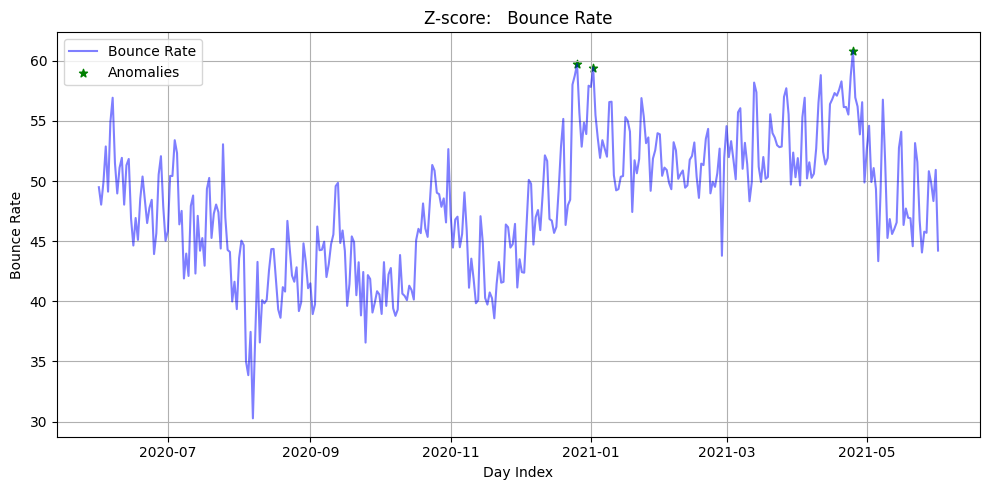


7 anomalies in Sessions


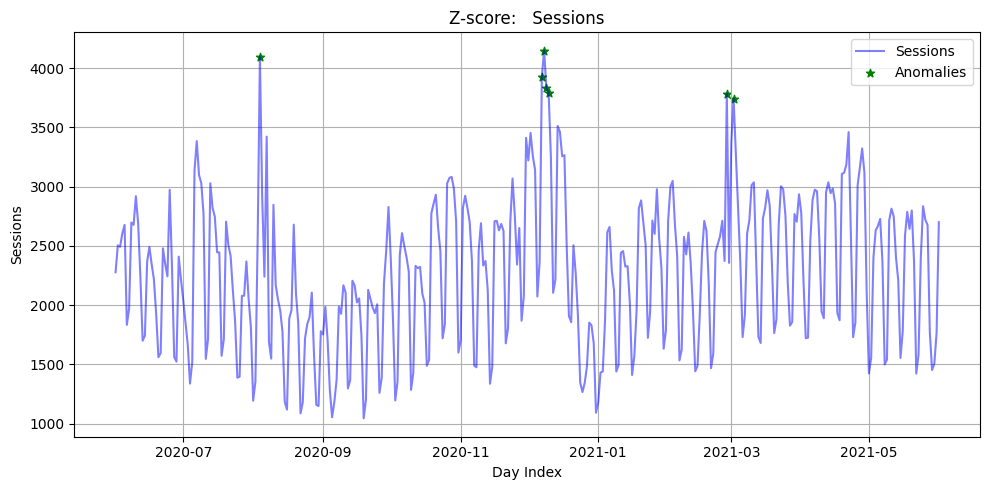


10 anomalies in Avg. Session Duration


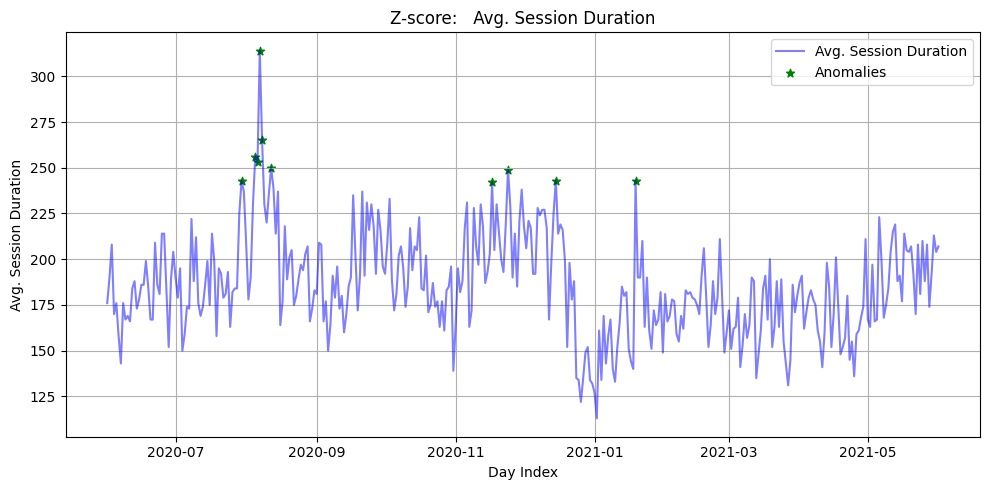

In [5]:
# Z-score
for df in dfs:
    df_zscore = df[[df.name]].apply(zscore)
    threshold = 2
    df_anomalies = df[(df_zscore > threshold).any(axis = 1)]
    save_and_show("Z-score", df, df_anomalies)


10 anomalies in Bounce Rate


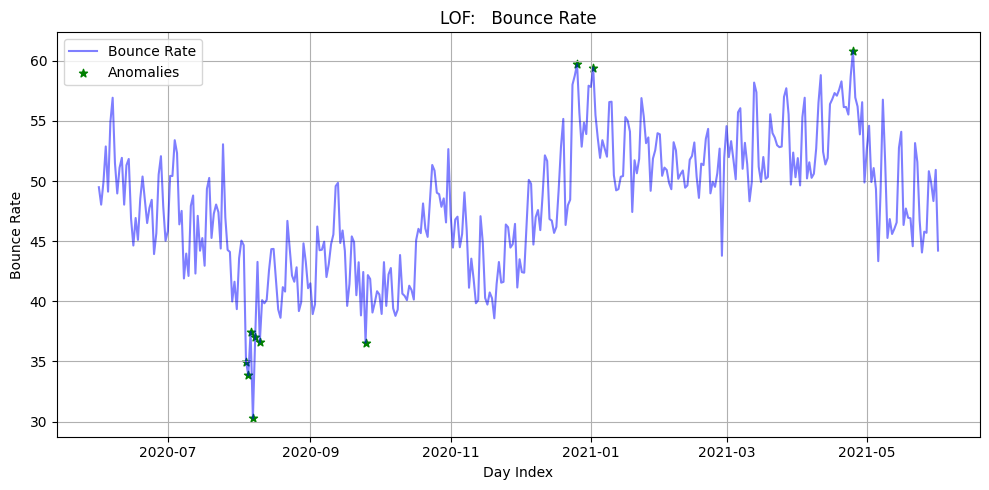


7 anomalies in Sessions


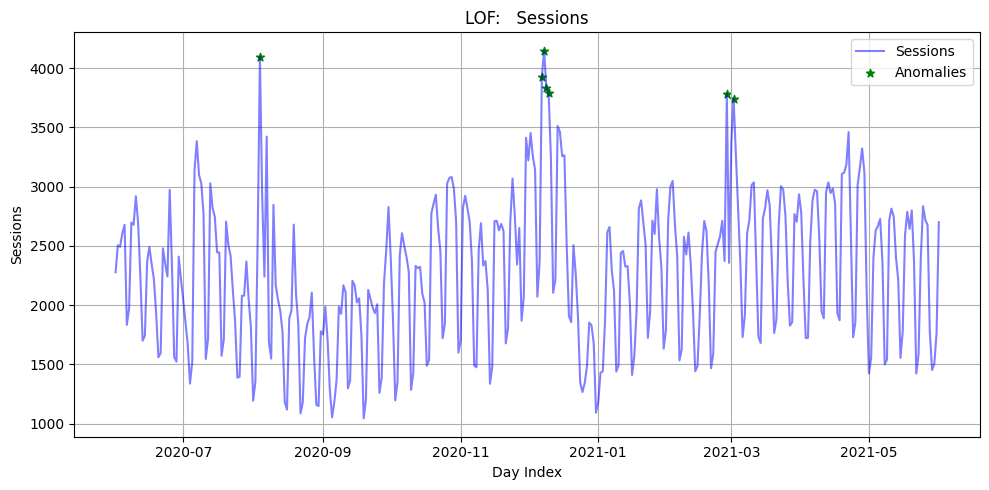


8 anomalies in Avg. Session Duration


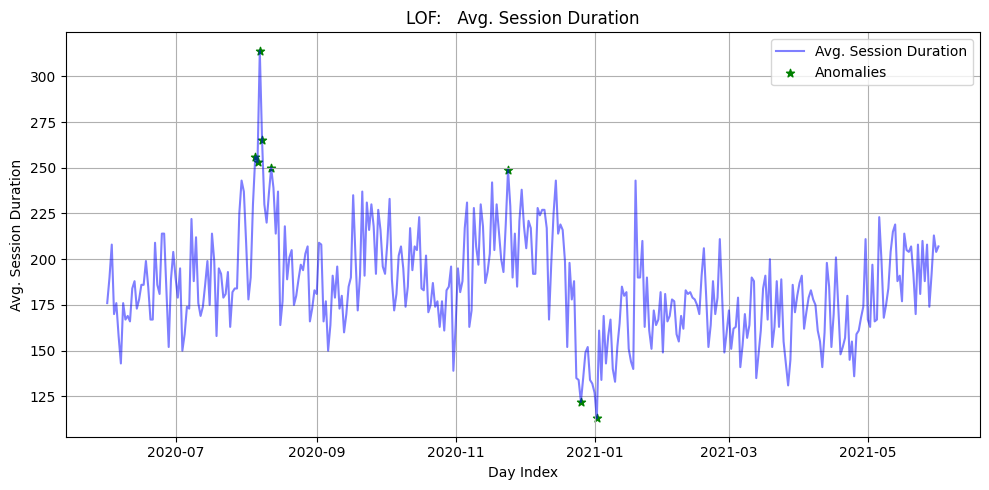

In [6]:
# Local Outlier Factor (LOF)
for df in dfs:
    X = df[[df.name]].values.reshape(-1, 1)
    lof = LocalOutlierFactor(n_neighbors = 19)
    anomaly_scores = lof.fit_predict(X)
    df_anomalies = df[anomaly_scores == -1]
    save_and_show("LOF", df, df_anomalies)


0 anomalies in Bounce Rate


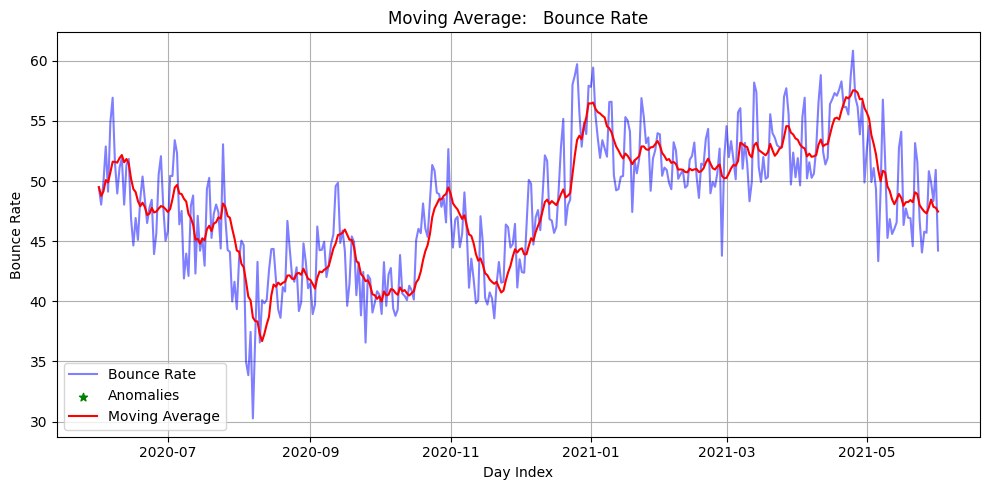


5 anomalies in Sessions


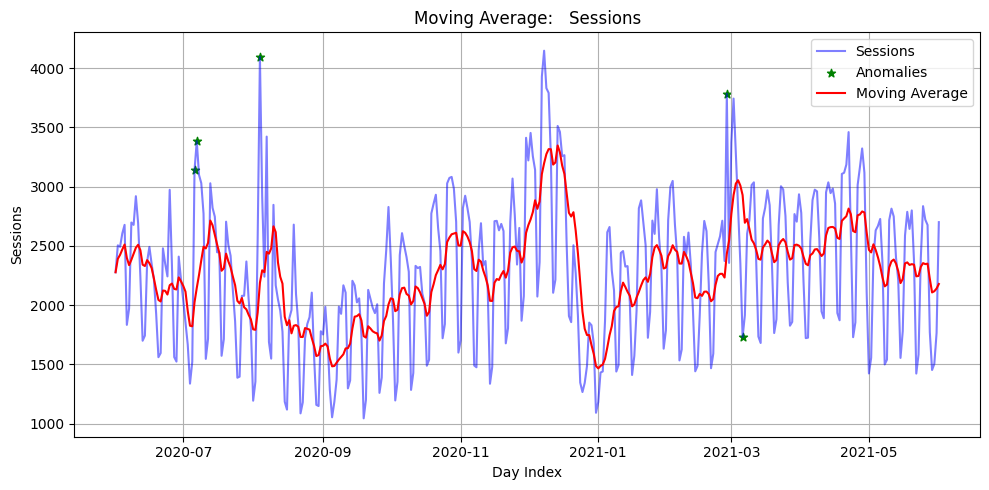


2 anomalies in Avg. Session Duration


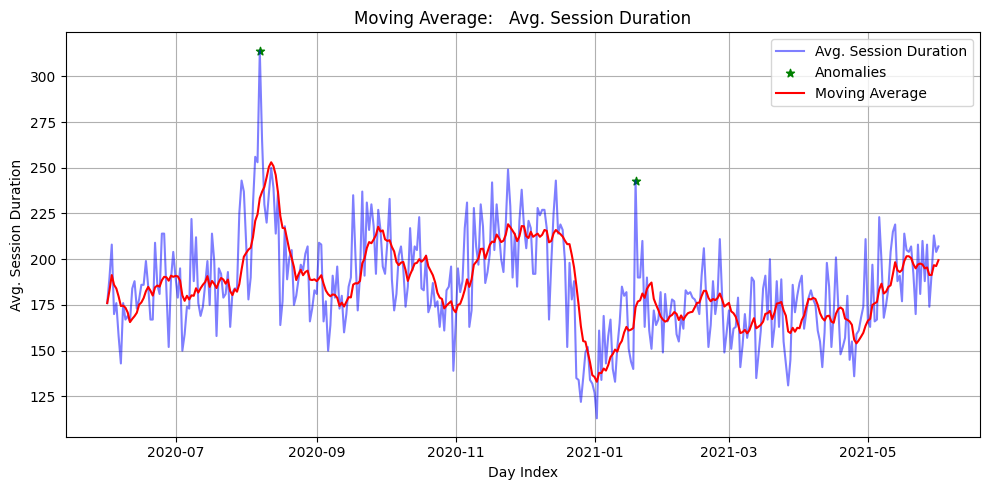

In [7]:
# Moving Average
for df in dfs:
    df_average = df.copy()

    # Calculate moving average
    window_size = 8
    df_average["Moving Average"] = df_average[df.name].rolling(window = window_size, min_periods = 1).mean()

    # Find anomalies based on moving average
    threshold = 3
    deviation = abs(df_average[df.name] - df_average["Moving Average"])
    std_threshold = threshold * df_average["Moving Average"].std()
    df_anomalies = df_average[deviation > std_threshold]
    save_and_show("Moving Average", df, df_anomalies, df_average)


3 anomalies in Bounce Rate


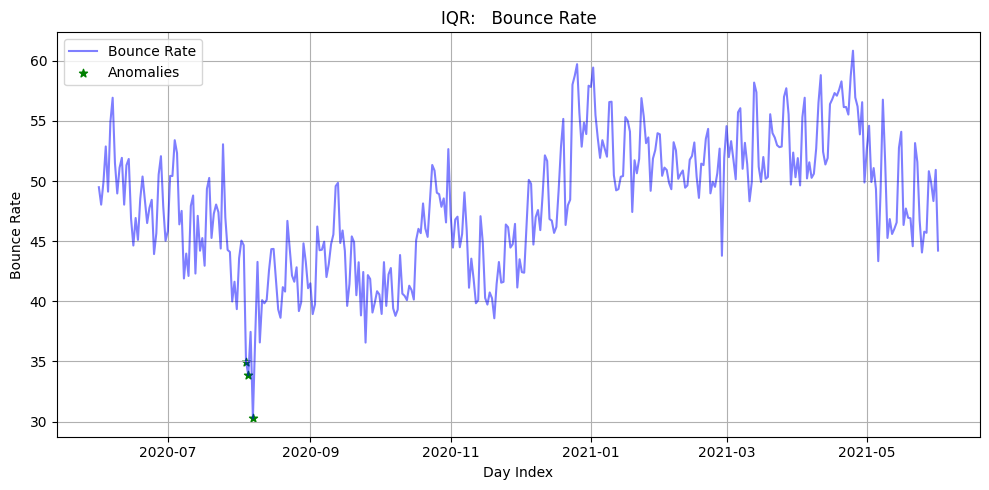


3 anomalies in Sessions


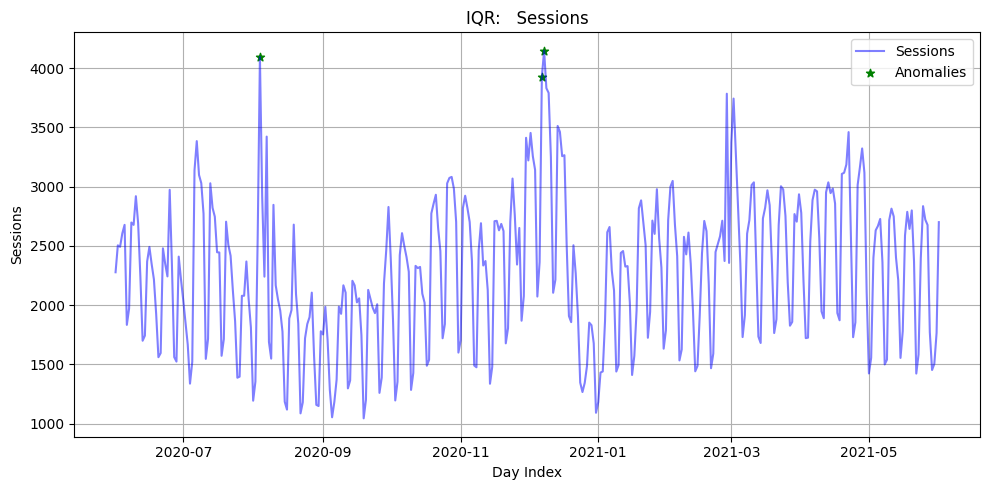


8 anomalies in Avg. Session Duration


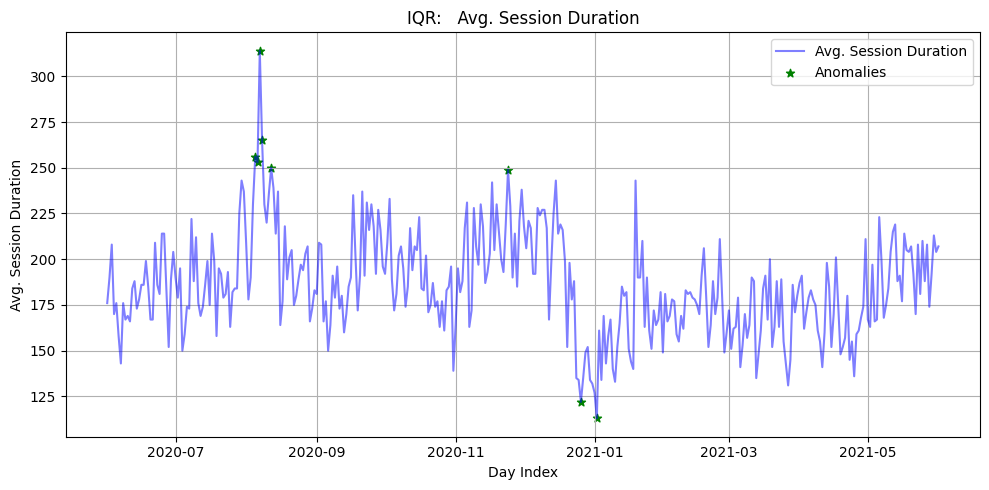

In [8]:
# Interquartile Range (IQR)
for df in dfs:
    # Get 1st and 3rd quartiles of the data
    q1 = df[df.name].quantile(0.25)
    q3 = df[df.name].quantile(0.75)
    iqr = q3 - q1

    # Define the upper and lower bounds
    alpha = 1.2
    lower_bound = q1 - (alpha * iqr)
    upper_bound = q3 + (alpha * iqr)
    df_anomalies = df[(df[df.name] < lower_bound) | (df[df.name] > upper_bound)]
    save_and_show("IQR", df, df_anomalies)